# plot results for the report

In [4]:
#!/usr/bin/env python
# coding: utf-8

# Plot benchmarks using existing run data

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import sys


#CSV_PATH = sys.argv[1]
#CSV_PATH = "results/2021-12-21-22:28:47_presentation_run__powers of 2"
#CSV_PATH = "results/2021-12-21-23:03:35_presentation run_1 to100 floats"
CSV_PATH = "results/2021-12-22-01:33:26_presentation run_25 step to 500"


# use LaTeX fonts in the plot
#plt.rc('text', usetex=True) # requires latex installation
plt.rc('font', family='sans serif')

font = {'size'   : 14}
matplotlib.rc('font', **font)

fontdict = {'fontsize': 14,
                'fontweight': 'bold'}

baseline_color = '#16193B'
warp_color = '#35478C'
block_color = '#4E7AC7'


header = ['version', 'workload', 'runs', 'warmup', 'blocks', 'threads_per_block', 'num_floats', 'malloc_mean', 'malloc_max', 'free_mean', 'free_max', 'work_mean', 'work_max']
df = pd.read_csv(CSV_PATH+"/out.csv", names = header, header = 0, delimiter = ' ')


# single plot
def plot_floats_vs_cycles(df, ax, params):
        
    # filter for data that fits the given parameters
    block_mask = df['blocks'] == params['blocks']
    threads_mask = df['threads_per_block'] == params['threads_per_block']
    workload_mask = df['workload'] == params['workload']
    df = df[block_mask & threads_mask & workload_mask]
    
    if params['num_floats'] >= 0:
        float_mask = df['num_floats'] <= params['num_floats']
        df = df[float_mask]
    
    
    # calculate mean and std over all runs
    df = df.groupby(['num_floats', 'version'], as_index=False)\
           .agg({'malloc_mean':['mean','std'], 'malloc_max':['mean', 'std'],\
                 'free_mean':['mean','std'],   'free_max':['mean', 'std'],\
                 'work_mean':['mean','std'],   'work_max':['mean', 'std']}\
               )
    
   
    floats = list(df['num_floats'].unique())
    
    # select versions to plot
    if len(params['versions']) != 0:
        versions = params['versions']
    else:
        versions = list(df['version'].unique())
    
    # plot lines
    measurement_type = params['measurement_type'] # is either "malloc", "work", or "free"
    aggregation_type = params['aggregation_type'] # is either "mean" or "max"
    ax.set_title(measurement_type)
    # baseline reference
    reference_mean = df[df['version'] == versions[0]][measurement_type + '_' + aggregation_type]['mean']
    
    for version in versions:
        mean = df[df['version'] == version][measurement_type + '_' + aggregation_type]['mean']
        std = df[df['version'] == version][measurement_type + '_' + aggregation_type]['std']
        
        # relative speedup to first version (baseline)
        if params['show_speedup']:
            speedup = np.asarray(reference_mean) / np.asarray(mean)
            #ax.plot(floats, speedup, label=str(version))
            ax.scatter(floats, speedup, label=str(version))
            ax.set_ylabel("relative speedup")
        else:
            ax.errorbar(floats, mean, std, label=str(version), fmt='--D') #fmt='.',
            #ax.set_ylabel("#clock cycles")
    
    #ax.legend()
    #ax.set_xlabel("#floats")
    return
   
    
# for the report use performance plot (Gflops)
def plot_flops(df, ax, params):
        
    # filter for data that fits the given parameters
    block_mask = df['blocks'] == params['blocks']
    threads_mask = df['threads_per_block'] == params['threads_per_block']
    workload_mask = df['workload'] == params['workload']
    df = df[block_mask & threads_mask & workload_mask]
    
    if params['num_floats'] >= 0:
        float_mask = df['num_floats'] <= params['num_floats']
        df = df[float_mask]
    
    
    # calculate mean and std over all runs
    #df = df.groupby(['num_floats', 'version'], as_index=False)\
    #       .agg({'malloc_mean':['mean','std'], 'malloc_max':['mean', 'std'],\
    #             'free_mean':['mean','std'],   'free_max':['mean', 'std'],\
    #             'work_mean':['mean','std'],   'work_max':['mean', 'std']}\
    #           )
    
   
    floats = list(df['num_floats'].unique())
    
    # select versions to plot
    if len(params['versions']) != 0:
        versions = params['versions']
    else:
        versions = list(df['version'].unique())
    
    # plot lines
    measurement_type = params['measurement_type'] # is either "malloc", "work", or "free"
    aggregation_type = params['aggregation_type'] # is either "mean" or "max"
    ax.set_title(measurement_type)
    # baseline reference
    #reference_mean = df[df['version'] == versions[0]][measurement_type + '_' + aggregation_type]['mean']
    
    
    
    
    
    for version in versions:
        #mean = df[df['version'] == version][measurement_type + '_' + aggregation_type]['mean']
        #std = df[df['version'] == version][measurement_type + '_' + aggregation_type]['std']
        
        
        baseline = df[df['version'] == 'baseline'][[measurement_type + '_' + aggregation_type, 'num_floats']]
        baseline.sort_values(by=['num_floats'])
        all_val = df[df['version'] == version][[measurement_type + '_' + aggregation_type, 'num_floats']]
        all_val.sort_values(by=['num_floats'])
        #print(all_val)
        
        pd_floats = all_val['num_floats']
        cycles = all_val[measurement_type + '_' + aggregation_type]
        cycles_baseline = baseline[measurement_type + '_' + aggregation_type]
        #print(cycles)
        
        # calculate flops
        base_clock = 1.291e9 # Ghz, cycles per second
        total_threads = params['blocks'] * params['threads_per_block']
        
        time = (cycles / base_clock)
        time_baseline = (cycles_baseline / base_clock)
        #print(time)
        #print(time_baseline)
        
        if (params['workload'] == 'sum_reduce'):
             # n adds
            work = (pd_floats * total_threads)
        elif (params['workload'] == 'sum_all_prod'):
            # n^2 mults, n adds
            work = ((pd_floats * pd_floats + pd_floats) * total_threads)
            
        #print(work)
        #print(time)
        #print(time_baseline)
        
        perf = work / time
        perf_baseline = work / time_baseline.values
        #print(perf)
        #print(perf_baseline)
        
        # speedup vs baseline
        speedup = perf / perf_baseline
        
        # convert to Gflop/s
        perf = perf * 1e-9
        perf_baseline = perf_baseline * 1e-9
        
        
        
        perf = perf.to_frame('perf')
        perf = perf.join(pd_floats)
        speedup = speedup.to_frame('speedup')
        speedup = speedup.join(pd_floats)
        
        
        # calculate mean and std over all runs
        perf = perf.groupby('num_floats', as_index=False)\
               .agg({'perf':['mean','std']})
        
        speedup = speedup.groupby('num_floats', as_index=False)\
               .agg({'speedup':['mean','std']})
        #print(perf)
        #print(speedup)
        
        
        # print speedup values
        if False:
            
            print('Perf. Speedup '+version+' '+params['workload'])
            print('floats 100, 200, 300, 400. mean (+-std):')
            sp1_mean = speedup[speedup['num_floats'] == 100]['speedup']['mean'].values[0]
            sp2_mean = speedup[speedup['num_floats'] == 200]['speedup']['mean'].values[0]
            sp3_mean = speedup[speedup['num_floats'] == 300]['speedup']['mean'].values[0]
            sp4_mean = speedup[speedup['num_floats'] == 400]['speedup']['mean'].values[0]
            
            sp1_std = speedup[speedup['num_floats'] == 100]['speedup']['std'].values[0]
            sp2_std = speedup[speedup['num_floats'] == 200]['speedup']['std'].values[0]
            sp3_std = speedup[speedup['num_floats'] == 300]['speedup']['std'].values[0]
            sp4_std = speedup[speedup['num_floats'] == 400]['speedup']['std'].values[0]
            #print(sp1['mean'].values[0])
            #print(f'{sp1_mean:.2f} (+-{sp1_std:.2f})')
            #print(f'{sp2_mean:.2f} (+-{sp2_std:.2f})')
            #print(f'{sp3_mean:.2f} (+-{sp3_std:.2f})')
            #print(f'{sp4_mean:.2f} (+-{sp4_std:.2f})')
            
            print(f'${sp1_mean:.2f} \\pm{sp1_std:.2f}$ & ', end="")
            print(f'${sp2_mean:.2f} \\pm{sp2_std:.2f}$ & ', end="")
            print(f'${sp3_mean:.2f} \\pm{sp3_std:.2f}$ & ', end="")
            print(f'${sp4_mean:.2f} \\pm{sp4_std:.2f}$ & ')
           
        # print malloc free times
        if True:
            print('Malloc/Free timings '+version+' '+params['workload'])
            print('floats 100, 200, 300, 400. mean (+-std):')
            
            malloc_free = df[df['version'] == version][['malloc_mean', 'free_mean', 'num_floats']]
            # calculate mean and std over all runs
            malloc_free = malloc_free.groupby('num_floats', as_index=False)\
                .agg({'malloc_mean':['mean','std'], 'free_mean':['mean','std']})
            
            
            # get malloc time in mili_seconds, free time in mili seconds
            malloc_free['malloc_mean'] = malloc_free['malloc_mean'] / base_clock * 1e3
            malloc_free['free_mean'] = malloc_free['free_mean'] / base_clock * 1e3
            #print(malloc_free)
            
            print('malloc: ', end="")
            for f in [100, 200, 300, 400]:
                m_mean = malloc_free[malloc_free['num_floats'] == f]['malloc_mean']['mean'].values[0]
                m_std = malloc_free[malloc_free['num_floats'] == f]['malloc_mean']['std'].values[0]
                
                print(f'${m_mean:.2f} \\pm{m_std:.2f}$ & ', end="")
            
            print()
            print('free: ', end="")
            for f in [100, 200, 300, 400]:
                f_mean = malloc_free[malloc_free['num_floats'] == f]['free_mean']['mean'].values[0]
                f_std = malloc_free[malloc_free['num_floats'] == f]['free_mean']['std'].values[0]
                
                print(f'${f_mean:.2f} \\pm{f_std:.2f}$ & ', end="")
            print()
        
        
        
        # style for different lines
        #'baseline', 'v1_martin',      'v3_nils',           'v5_anton',      'v6_nils'
        #'baseline', 'header + block', 'no-header + block', 'header + warp', 'no-header + warp'
        fmt='--D'
        color='k'
        alpha = 1
        if version == 'baseline':
            fmt='-o'
            color=baseline_color
        elif version == 'v1_martin':
            fmt='-s'
            color=block_color
            alpha = 1
        elif version == 'v3_nils':
            fmt='-D'
            color=block_color
            alpha = 1
        elif version == 'v5_anton':
            fmt='-v'
            color=warp_color
            alpha = 1
        elif version == 'v6_nils':
            fmt='-^'
            color=warp_color
            alpha = 1
        
        _,_, errbar = ax.errorbar(floats, perf['perf']['mean'], perf['perf']['std'], label=str(version), fmt=fmt,alpha=alpha, color=color) #fmt='.',
        [bar.set_alpha(0.3) for bar in errbar]
        
        #ax.set_ylabel("#clock cycles")
    
    #ax.legend()
    #ax.set_xlabel("#floats")
    return

    
# extract range of parameters
versions = list(df['version'].unique())
workloads = list(df['workload'].unique())
runs = list(df['runs'].unique())
warmups = list(df['warmup'].unique())
blocks = list(df['blocks'].unique())
threads_per_block = list(df['threads_per_block'].unique())
num_floats = list(df['num_floats'].unique())
measurement_types = ['malloc', 'work', 'free']

def plot_workloads_vs_measurement_type():
    ## plot (workloads) vs (malloc, work, free)
    fig, axs = plt.subplots(len(workloads), 3, sharey=False, sharex=True, figsize=(15, len(workloads)*5))
    # constant parameters
    n_blocks = 192
    n_threads_per_block = 64
    n_floats = 10
    versions = [] # all
    aggregation_type = 'mean' # or max
    show_speedup = False
    
    fig.suptitle("Parameters:" \
              + " blocks: " + str(n_blocks)\
              + ", threads per block: " + str(n_threads_per_block)\
              + ", aggregation type: " + str(aggregation_type)\
              + ", runs: " + str(runs)\
              + ", warmup runs: " + str(warmups) + ",\n"\
              + "workloads top-to-bottom: " + str(workloads))
    #fig.supxlabel('Measurement type')
    #fig.supylabel('Workload')

    for w, workload in enumerate(workloads):
        for i, measurement_type in enumerate(measurement_types):
            params = {'measurement_type': measurement_type,
                      'blocks': 192,
                      'threads_per_block': 64,
                      'workload': workload,
                      'num_floats': n_floats,
                      'versions': versions,
                      'aggregation_type': aggregation_type,
                      'show_speedup': show_speedup}
            if len(workloads) == 1:
                ax = axs[i]
            else:
                ax = axs[w][i]
            plot_floats_vs_cycles(df, ax, params)

    plt.savefig(CSV_PATH+"/workload_vs_measurement_type.png", dpi=60, bbox_inches='tight')   
    plt.show()





Runtime of linear workload

All versions
Parameters: aggregation type: mean, runs: [20], warmup runs: [2],

Malloc/Free timings baseline sum_reduce
floats 100, 200, 300, 400. mean (+-std):
malloc: $10.37 \pm0.36$ & $57.30 \pm1.28$ & $294.74 \pm5.46$ & $296.95 \pm5.11$ & 
free: $0.06 \pm0.03$ & $0.10 \pm0.04$ & $0.57 \pm0.30$ & $0.79 \pm0.42$ & 
Malloc/Free timings v1_martin sum_reduce
floats 100, 200, 300, 400. mean (+-std):
malloc: $0.13 \pm0.01$ & $0.20 \pm0.03$ & $0.32 \pm0.08$ & $0.35 \pm0.10$ & 
free: $0.01 \pm0.00$ & $0.01 \pm0.00$ & $0.02 \pm0.00$ & $0.02 \pm0.00$ & 
Malloc/Free timings v3_nils sum_reduce
floats 100, 200, 300, 400. mean (+-std):
malloc: $1.62 \pm0.01$ & $1.63 \pm0.01$ & $1.63 \pm0.01$ & $1.61 \pm0.01$ & 
free: $0.07 \pm0.02$ & $0.08 \pm0.02$ & $0.08 \pm0.02$ & $0.07 \pm0.02$ & 
Malloc/Free timings v5_anton sum_reduce
floats 100, 200, 300, 400. mean (+-std):
malloc: $1.09 \pm0.81$ & $2.11 \pm1.73$ & $7.28 \pm3.31$ & $7.49 \pm3.29$ & 
free: $0.08 \pm0.02$ & $0.15 \pm0.07$ & $0.47 \pm0.20$ & 

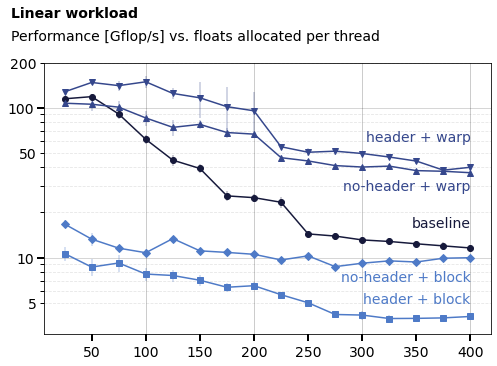

In [5]:
def plot_worktime(ver, legend, suffix):
    ## plot cycles vs number of floats
    threads_per_block = [1024]
    fig, ax = plt.subplots(1, 1, sharey='row', sharex=True, figsize=(8, 5))
    # constant parameters
    n_floats = 400
    versions = ver
    aggregation_type = 'mean' # or max
    show_speedup = False
   
    
    
    print("Parameters:" \
              + " aggregation type: " + str(aggregation_type)\
              + ", runs: " + str(runs)\
              + ", warmup runs: " + str(warmups) + ",\n")
    #fig.suptitle()
    #fig.supxlabel('Measurement type')
    #fig.supylabel('Workload')

    
        
    params = {'measurement_type': 'work',
              'blocks': 12,
              'threads_per_block': 1024,
              'workload': 'sum_reduce',
              'num_floats': n_floats,
              'versions': versions,
              'aggregation_type': aggregation_type,
              'show_speedup': show_speedup}
    
    #plot_floats_vs_cycles(df, ax, params)
    plot_flops(df, ax, params)
    #ax.set_title("Performance of the linear workload", fontdict=fontdict)
    ax.set_title("", fontdict=fontdict)
    #axs[1][b].set_xlabel("#floats")
    
    
    
    ax.grid(True, axis='y', which='major', color='k', linestyle='-', alpha=0.2)
    ax.grid(True, axis='y', which='minor', color='k', linestyle='--', alpha=0.1)
    
    
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=7)
    ax.tick_params(which='minor', width=1, length=4, color='k')
    
    
    
    #ax.set_xscale("log", base=2)
    ax.set_yscale("log", base=10)
    ax.yaxis.set_label_coords(0.125,1.1)
    
    
    #majors = [10, 100]
    #ax.yaxis.set_major_locator(ticker.FixedLocator(majors), labels=[10, 100])
    #minors = [5, 50, 200]
    #ax.yaxis.set_minor_locator(ticker.FixedLocator(minors))
    
    
    ax.set_yticks(ticks=[10, 100], labels=[10, 100], minor=False)
    ax.set_yticks(ticks=[5, 6, 7, 8, 9, 20, 30, 40, 50, 60, 70, 80, 90, 200], labels=[5,'','','','','','','', 50,'','','','', 200], minor=True)
    
    
    vline_c = 'k'
    vline_st = '-'
    vline_al = 0.2
    vline_wi = 1
    plt.axvline(100, 0, 1, color=vline_c, linestyle=vline_st, alpha=vline_al, linewidth=vline_wi)
    plt.axvline(200, 0, 1, color=vline_c, linestyle=vline_st, alpha=vline_al, linewidth=vline_wi)
    plt.axvline(300, 0, 1, color=vline_c, linestyle=vline_st, alpha=vline_al, linewidth=vline_wi)
    plt.axvline(400, 0, 1, color=vline_c, linestyle=vline_st, alpha=vline_al, linewidth=vline_wi)
    
    plt.text(-25, 400, "Linear workload", fontdict=fontdict)
    plt.text(-25, 280, "Performance [Gflop/s] vs. floats allocated per thread")
    
    #ax.set_xlabel("Number of floats allocated per thread", fontdict=fontdict)
    
    #ax.legend(legend)
    plt.text(400, 16, "baseline", color=baseline_color, ha='right')
    plt.text(400, 5, "header + block", color=block_color, ha='right')
    plt.text(400, 7, "no-header + block", color=block_color, ha='right')
    plt.text(400, 60, "header + warp", color=warp_color, ha='right')
    plt.text(400, 28, "no-header + warp", color=warp_color, ha='right')
    #plt.text(0.08, 0.2, 'sin')
    
    #ax.set_ylabel("sum_reduce", fontdict=fontdict)
    #axs.set_ylabel("sum_all_prod", fontdict=fontdict)
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    #fig.text(0.5, 1.0, '[blocks, threads per block]', ha='center', va='center', fontsize=20)
    #fig.text(0.0, 0.5, 'Time [#clock cycles]', ha='center', va='center', rotation='vertical', fontsize=20)
    #ig.text(0.5, 0.0, 'Number of floats allocated', ha='center', va='center', fontsize=20)
    #ig.align_ylabels()
    #ig.tight_layout()
    
    
    
    plt.savefig(CSV_PATH+'/report_performance linear workload.pdf', bbox_inches='tight')
    
    #plt.savefig(CSV_PATH+"/report_runtime linear workload.png", dpi=120, bbox_inches='tight')   
    plt.show()
    
print("All versions")
plot_worktime(['baseline', 'v1_martin', 'v3_nils', 'v5_anton', 'v6_nils'], ['baseline', 'header + block', 'no-header + block', 'header + warp', 'no-header + warp'], "all_versions")


quadratic workload

All versions
Parameters: aggregation type: mean, runs: [20], warmup runs: [2],

Malloc/Free timings baseline sum_all_prod
floats 100, 200, 300, 400. mean (+-std):
malloc: $17.99 \pm0.37$ & $93.21 \pm1.07$ & $382.89 \pm5.46$ & $438.36 \pm5.62$ & 
free: $2.21 \pm0.32$ & $12.90 \pm1.60$ & $39.55 \pm4.78$ & $72.54 \pm7.38$ & 
Malloc/Free timings v1_martin sum_all_prod
floats 100, 200, 300, 400. mean (+-std):
malloc: $0.18 \pm0.02$ & $0.25 \pm0.04$ & $0.25 \pm0.04$ & $0.23 \pm0.05$ & 
free: $0.01 \pm0.00$ & $0.01 \pm0.00$ & $0.01 \pm0.00$ & $0.01 \pm0.00$ & 
Malloc/Free timings v3_nils sum_all_prod
floats 100, 200, 300, 400. mean (+-std):
malloc: $1.63 \pm0.02$ & $1.65 \pm0.02$ & $1.65 \pm0.02$ & $1.64 \pm0.02$ & 
free: $0.12 \pm0.02$ & $0.22 \pm0.03$ & $0.28 \pm0.03$ & $0.39 \pm0.05$ & 
Malloc/Free timings v5_anton sum_all_prod
floats 100, 200, 300, 400. mean (+-std):
malloc: $4.36 \pm1.76$ & $9.68 \pm1.31$ & $13.02 \pm3.33$ & $13.25 \pm3.50$ & 
free: $2.34 \pm1.18$ & $3.51 \pm2.79$ & $9.6

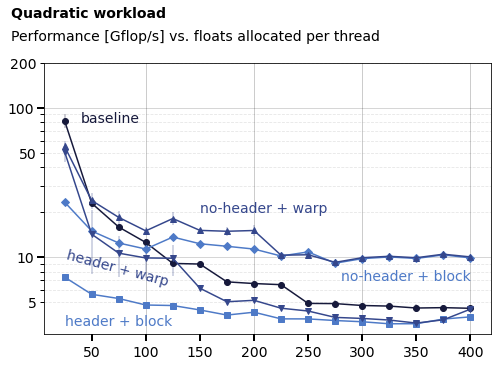

In [6]:
def plot_worktime(ver, legend, suffix):
    ## plot cycles vs number of floats
    threads_per_block = [1024]
    fig, ax = plt.subplots(1, 1, sharey='row', sharex=True, figsize=(8, 5))
    # constant parameters
    n_floats = 400
    versions = ver
    aggregation_type = 'mean' # or max
    show_speedup = False
   
    
    
    print("Parameters:" \
              + " aggregation type: " + str(aggregation_type)\
              + ", runs: " + str(runs)\
              + ", warmup runs: " + str(warmups) + ",\n")
    #fig.suptitle()
    #fig.supxlabel('Measurement type')
    #fig.supylabel('Workload')

    
        
    params = {'measurement_type': 'work',
              'blocks': 12,
              'threads_per_block': 1024,
              'workload': 'sum_all_prod',
              'num_floats': n_floats,
              'versions': versions,
              'aggregation_type': aggregation_type,
              'show_speedup': show_speedup}
    
    #plot_floats_vs_cycles(df, ax, params)
    plot_flops(df, ax, params)
    #ax.set_title("Performance of the linear workload", fontdict=fontdict)
    ax.set_title("", fontdict=fontdict)
    #axs[1][b].set_xlabel("#floats")
    
    
    
    ax.grid(True, axis='y', which='major', color='k', linestyle='-', alpha=0.2)
    ax.grid(True, axis='y', which='minor', color='k', linestyle='--', alpha=0.1)
    
    
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=7)
    ax.tick_params(which='minor', width=1, length=4, color='k')
    
    
    
    #ax.set_xscale("log", base=2)
    ax.set_yscale("log", base=10)
    ax.yaxis.set_label_coords(0.125,1.1)
    
    
    #majors = [10, 100]
    #ax.yaxis.set_major_locator(ticker.FixedLocator(majors), labels=[10, 100])
    #minors = [5, 50, 200]
    #ax.yaxis.set_minor_locator(ticker.FixedLocator(minors))
    
    
    ax.set_yticks(ticks=[10, 100], labels=[10, 100], minor=False)
    ax.set_yticks(ticks=[5, 6, 7, 8, 9, 20, 30, 40, 50, 60, 70, 80, 90, 200], labels=[5,'','','','','','','', 50,'','','','', 200], minor=True)
    
    
    vline_c = 'k'
    vline_st = '-'
    vline_al = 0.2
    vline_wi = 1
    plt.axvline(100, 0, 1, color=vline_c, linestyle=vline_st, alpha=vline_al, linewidth=vline_wi)
    plt.axvline(200, 0, 1, color=vline_c, linestyle=vline_st, alpha=vline_al, linewidth=vline_wi)
    plt.axvline(300, 0, 1, color=vline_c, linestyle=vline_st, alpha=vline_al, linewidth=vline_wi)
    plt.axvline(400, 0, 1, color=vline_c, linestyle=vline_st, alpha=vline_al, linewidth=vline_wi)
    
    plt.text(-25, 400, "Quadratic workload", fontdict=fontdict)
    plt.text(-25, 280, "Performance [Gflop/s] vs. floats allocated per thread")
    
    #ax.set_xlabel("Number of floats allocated per thread", fontdict=fontdict)
    
    #ax.legend(legend)
    plt.text(40, 80, "baseline", color=baseline_color, ha='left')
    plt.text(25, 3.5, "header + block", color=block_color, ha='left')
    plt.text(400, 7, "no-header + block", color=block_color, ha='right')
    plt.text(25, 6.5, "header + warp", color=warp_color, rotation=-15)
    plt.text(150, 20, "no-header + warp", color=warp_color, ha='left')
    
    #ax.set_ylabel("sum_reduce", fontdict=fontdict)
    #axs.set_ylabel("sum_all_prod", fontdict=fontdict)
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    #fig.text(0.5, 1.0, '[blocks, threads per block]', ha='center', va='center', fontsize=20)
    #fig.text(0.0, 0.5, 'Time [#clock cycles]', ha='center', va='center', rotation='vertical', fontsize=20)
    #ig.text(0.5, 0.0, 'Number of floats allocated', ha='center', va='center', fontsize=20)
    #ig.align_ylabels()
    #ig.tight_layout()
    
    
    
    plt.savefig(CSV_PATH+'/report_performance quadratic workload.pdf', bbox_inches='tight')
    
    #plt.savefig(CSV_PATH+"/report_runtime linear workload.png", dpi=120, bbox_inches='tight')   
    plt.show()
    
print("All versions")
plot_worktime(['baseline', 'v1_martin', 'v3_nils', 'v5_anton', 'v6_nils'], ['baseline', 'header + block', 'no-header + block', 'header + warp', 'no-header + warp'], "all_versions")


Runtime of quadratic workload

All versions
Parameters: aggregation type: mean, runs: [20], warmup runs: [2],



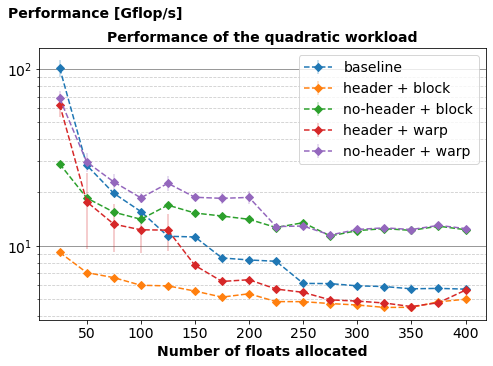

In [48]:
def plot_worktime(ver, legend, suffix):
    ## plot cycles vs number of floats
    threads_per_block = [1024]
    fig, ax = plt.subplots(1, 1, sharey='row', sharex=True, figsize=(8, 5))
    # constant parameters
    n_floats = 400
    versions = ver
    aggregation_type = 'mean' # or max
    show_speedup = False
   
    
    
    print("Parameters:" \
              + " aggregation type: " + str(aggregation_type)\
              + ", runs: " + str(runs)\
              + ", warmup runs: " + str(warmups) + ",\n")
    #fig.suptitle()
    #fig.supxlabel('Measurement type')
    #fig.supylabel('Workload')

    
        
    params = {'measurement_type': 'work',
              'blocks': 12,
              'threads_per_block': 1024,
              'workload': 'sum_all_prod',
              'num_floats': n_floats,
              'versions': versions,
              'aggregation_type': aggregation_type,
              'show_speedup': show_speedup}
    
    #plot_floats_vs_cycles(df, ax, params)
    plot_flops(df, ax, params)
    ax.set_title("Performance of the quadratic workload", fontdict=fontdict)
    #axs[1][b].set_xlabel("#floats")
    ax.grid(True, axis='y', which='major', color='k', linestyle='-', alpha=0.5)
    ax.grid(True, axis='y', which='minor', color='k', linestyle='--', alpha=0.2)
    #ax.set_xscale("log", base=2)
    ax.set_yscale("log", base=10)
    
    ax.set_ylabel("Performance [Gflop/s]", rotation=0, fontdict=fontdict)
    ax.yaxis.set_label_coords(0.125,1.1)
    ax.set_xlabel("Number of floats allocated", fontdict=fontdict)
    
    ax.legend(legend)
    #ax.set_ylabel("sum_reduce", fontdict=fontdict)
    #axs.set_ylabel("sum_all_prod", fontdict=fontdict)
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    #fig.text(0.5, 1.0, '[blocks, threads per block]', ha='center', va='center', fontsize=20)
    #fig.text(0.0, 0.5, 'Time [#clock cycles]', ha='center', va='center', rotation='vertical', fontsize=20)
    #ig.text(0.5, 0.0, 'Number of floats allocated', ha='center', va='center', fontsize=20)
    #ig.align_ylabels()
    #ig.tight_layout()
    
    
    
    plt.savefig(CSV_PATH+'/report_runtime quadratic workload.pdf', bbox_inches='tight')
    
    plt.show()
    
print("All versions")
plot_worktime(['baseline', 'v1_martin', 'v3_nils', 'v5_anton', 'v6_nils'], ['baseline', 'header + block', 'no-header + block', 'header + warp', 'no-header + warp'], "all_versions")


In [ ]:
def plot_workload_speedup(ver, legend, suffix):
    ## plot (blocks) vs (threads_per_block)
    fig, axs = plt.subplots(len(workloads), len(threads_per_block), sharey='row', sharex=True, figsize=(len(threads_per_block)*5, len(workloads)*5))
    # constant parameters
    n_floats = 400
    versions = ver
    aggregation_type = 'mean' # or max
    show_speedup = True
    
    
    print("Parameters:" \
              + " aggregation type: " + str(aggregation_type)\
              + ", runs: " + str(runs)\
              + ", warmup runs: " + str(warmups) + ",\n"\
              + "workloads top-to-bottom: " + str(workloads))
    #fig.suptitle()
    #fig.supxlabel('Measurement type')
    #fig.supylabel('Workload')

    for w, workload in enumerate(workloads):
        for b, block in enumerate(blocks):
        
            params = {'measurement_type': 'work',
                      'blocks': block,
                      'threads_per_block': threads_per_block[b],
                      'workload': workload,
                      'num_floats': n_floats,
                      'versions': versions,
                      'aggregation_type': aggregation_type,
                      'show_speedup': show_speedup}
            if len(workloads) == 1:
                ax = axs[b]
            else:
                ax = axs[w][b]
            plot_floats_vs_cycles(df, ax, params)
            ax.set_title("")
            axs[0][b].set_title("["+str(block)+", "+str(threads_per_block[b])+"]", fontdict=fontdict)
            #axs[1][b].set_xlabel("#floats")
            ax.grid(True)
            #ax.set_xscale("log", base=2)
            #ax.set_yscale("log", base=2)
        #axs[w][0].set_ylabel("#clock cycles")

    axs[0][0].legend(legend)
    axs[0][0].set_ylabel("sum_reduce", fontdict=fontdict)
    axs[1][0].set_ylabel("sum_all_prod", fontdict=fontdict)
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    fig.text(0.5, 1.0, '[blocks, threads per block]', ha='center', va='center', fontsize=20)
    fig.text(0.0, 0.5, 'Speedup over Baseline', ha='center', va='center', rotation='vertical', fontsize=20)
    fig.text(0.5, 0.0, 'Number of floats allocated', ha='center', va='center', fontsize=20)
    fig.align_ylabels()
    fig.tight_layout()
    plt.savefig(CSV_PATH+"/workload_speedup_" + suffix + ".png", dpi=120, bbox_inches='tight')   
    plt.show()
    
#print("Per block allocation")
#plot_workload_speedup(['baseline', 'v1_martin', 'v3_nils'], ['baseline', 'header + block', 'no-header + block'], "block")
#print("Per warp allocation")
#plot_workload_speedup(['baseline', 'v5_anton', 'v6_nils'], ['baseline', 'header + warp', 'no-header + warp'], "warp")

# all versions in one plot
plot_workload_speedup(['baseline', 'v1_martin', 'v3_nils', 'v5_anton', 'v6_nils'], ['baseline', 'header + block', 'no-header + block', 'header + warp', 'no-header + warp'], "all")